# **Working Process**
1. 데이터 수집하기
1. 수집데이터 전처리 NDBMS
1. Token 의 정리 (wordCloud)
1. N-Gram 의 정리 (메뉴명 PMI)
1. Clustering (군집화 묶기)
1. Token 간 관계 분석하기
1. 데이터 정리 및 모델링

1. 제목 단어들을 묶어서 **word Piece Model** 로 **유효단어** 추출하기
1. 유사한 그룹은 편집거리를 활용하여 묶기

In [16]:
text1 = "자연 언어에 대한 연구는 오래전부터 이어져 오고 있음에도 2018년까지도 사람처럼 이해하지는 못한다.".split()
text2 = "자연 언어에 대한 연구는 오래전부터 이어져 들어서도 아직 컴퓨터가 사람처럼 이해하지는 못한다.".split()
text3 = "자연 아직 컴퓨터가 언어에 들어서도 못한다 이어져 사람처럼 이해하지는 대한 연구는 오래전부터.".split()
len(text1), len(text2), len(text3)

(12, 12, 12)

In [17]:
from nltk.metrics import edit_distance
print(edit_distance('파이썬 알고리즘', '파파미 알탕'))

print('생략된 단어가 다를 때 : {} \n어휘 순서를 바꿨을 때 : {}'.format(
    edit_distance(text1, text2), 
    edit_distance(text2, text3)))

5
생략된 단어가 다를 때 : 3 
어휘 순서를 바꿨을 때 : 10


In [18]:
# 02 accuracy 정확도 측정
from nltk.metrics import accuracy
accuracy('파이썬', '파이프')

0.6666666666666666

In [19]:
print('생략된 단어가 다를 때 {:.4} \n어휘 순서를 바꿨을 때 {:.4}'.format(
    accuracy(text1, text2), 
    accuracy(text2, text3)))

생략된 단어가 다를 때 0.75 
어휘 순서를 바꿨을 때 0.08333


In [20]:
text1 = set(text1)
text2 = set(text2)
text3 = set(text3)
print(len(text1), len(text2), len(text3))
from nltk.metrics import precision
precision({'파이썬'}, {'파르썬'})

12 12 12


0.0

In [21]:
print('생략된 단어가 다를 때 {:.4} \n어휘 순서를 바꿨을 때 {:.4}'.format(
    precision(set(text1), set(text2)), 
    precision(set(text2), set(text3))))

생략된 단어가 다를 때 0.75 
어휘 순서를 바꿨을 때 0.8333


In [22]:
from nltk.metrics import recall
print('생략된 단어가 다를 때 {:.4} \n어휘 순서를 바꿨을 때 {:.4}'.format(
    recall(text1, text2), 
    recall(text2, text3)))

생략된 단어가 다를 때 0.75 
어휘 순서를 바꿨을 때 0.8333


# **Process Goal**
- 여러가지 작업방법을 사용하여 원하는 사전을 구축하는 것!!!
- 결국은 **사전을 구축하며 내용을 확인 가능해야 Huristic 개념에서 Algorithm 으로** 넘어갈 수 있다
- 음식과 메뉴 관련된 단어들만 추출가능하도록 모듈 구성하기
- Token 들 중 음식과 관련된 단어들만 찾기
- 유효한 값 2000개 중 음식과 관련 없는 것들만 제거하기

## **데이터 불러오기**
음식데이터는 Mecab() 보다 Okt() 가 더 효과적인 단어목록을 포함

In [61]:
import pandas as pd
df = pd.read_csv('data/foodmens.csv', header=None)
menuTitle = " ".join(df[1])

with open('menuTitles.txt', 'w') as f:
    f.write(menuTitle)
menuTitle[:400]

'호불호 없는 토마토파스타는 역시 ~! 토마토냉파스타 ★ 달콤 촉촉 달걀 푸딩 만들기, 만드는 법 ( 부드러운 달걀 요리 기본 원리 ) 손이가요 손이가~~자꾸 손이 가는 [가지전] 여름 무로 깔끔아삭 무채무침 흰 강낭콩 바나나 쉐이크 다이어트&아침 대용 깻잎절임 : 입맛 되살리는 초간단 반찬 소고기 장조림 만들기 간단반찬 으로 최고! 차돌박이 부추무침, 간단한 손님초대요리 버터롤빵 샌드위치 브런치로 먹었어요. 보양식/ 비 오는 날 딱 엄나무 한방 오리백숙! [암예방레시피]토마토절임. 수퍼푸드 토마토로 즐기는 저염식피클! 늙은 오이..노각오징어무침 간단하고 든든한 한끼! 불고기콩나물밥 간단요리...아귀수육 맛집 메뉴 그대로! 연안에서 먹는 느낌 살린 꼬막비빔밥★ 신김치 볶음(열무 얼갈이 물김치로 만들었어요) 암'

In [62]:
import re
with open('data/menuTitles.txt','r') as f:
    titles = f.read()

titles = re.findall(r"[가-힣]+", titles)
titles = " ".join(titles).lower()
titles_raw = titles.split(" ")

from collections import Counter
Counter(titles_raw).most_common(10)

[('만들기', 17272),
 ('만드는', 5212),
 ('법', 3829),
 ('회', 3736),
 ('초간단', 3560),
 ('레시피', 3392),
 ('만드는법', 2743),
 ('맛있는', 2650),
 ('좋은', 2386),
 ('맛있게', 2209)]

## **Nltk 객체를 활용한 가치있는 단어들 추출**
```python
# nltk 에서 분석가능한 객체를 자동으로 생성
# 식품메뉴명에는 Okt() 가 사전이 더 좋음
titles = Okt().pos(titles, stem=True)
```

In [63]:
%%time
import warnings
warnings.simplefilter('ignore')

from nltk import Text
from konlpy.tag import Mecab, Okt
titles_noun = Okt().nouns(titles)
title_obj = Text(titles_noun)

/home/markbaum/Python/nltk/lib/python3.6/site-packages/jpype/_core.py:210: UserWarning: 
-------------------------------------------------------------------------------
Deprecated: convertStrings was not specified when starting the JVM. The default
behavior in JPype will be False starting in JPype 0.8. The recommended setting
for new code is convertStrings=False.  The legacy value of True was assumed for
this session. If you are a user of an application that reported this warning,
please file a ticket with the developer.
-------------------------------------------------------------------------------

  """)


CPU times: user 2min 8s, sys: 597 ms, total: 2min 9s
Wall time: 1min 42s


In [67]:
# .B() : Unique 한 Token 갯수
# .N() : 전체 Token 의 갯수
title_obj.vocab().N(),  title_obj.vocab().B(),  int(title_obj.vocab().N()/title_obj.vocab().B())

(567992, 13459, 42)

In [68]:
from nltk import collocations

finder = collocations.BigramCollocationFinder.from_words(titles_noun)
measures = collocations.BigramAssocMeasures()
finder.nbest(measures.pmi, 20)

[('가까이', '쑥굴국'),
 ('감탄사', '연발'),
 ('갑농', '산이'),
 ('개두', '릎'),
 ('갯벌', '환경'),
 ('거성', '그룹'),
 ('검', '은빛'),
 ('검사', '외조'),
 ('검은색', '수상한'),
 ('결명자', '불우'),
 ('계정', '바오지'),
 ('고준희', '대사'),
 ('곶', '감전'),
 ('구성민', '뿔뽀'),
 ('국제', '캠퍼스'),
 ('궁보', '계정'),
 ('귤즙', '질퍽'),
 ('그룹', '구일'),
 ('글루', '코시'),
 ('금연', '의지')]

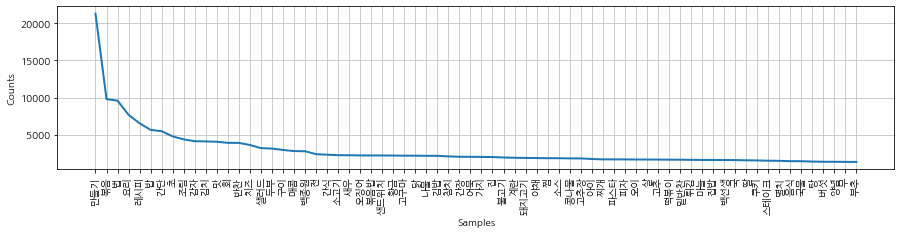

In [69]:
%matplotlib inline
from matplotlib import rc, rcParams
rc('font', family=['NanumGothic','Malgun Gothic']) # 한글의 표시
rcParams['axes.unicode_minus'] = False             # '-' 표시의 처리

import matplotlib.pyplot as plt
plt.figure(figsize=(15, 3))  # 파레트 설정
title_obj.plot(70)

In [7]:
maxLimits = 1950
title_obj.vocab().most_common(maxLimits)[(maxLimits-10):]

[('당', 25),
 ('퓨레', 25),
 ('과육', 25),
 ('통통', 25),
 ('우무', 25),
 ('이상민', 25),
 ('햄말', 25),
 ('스프레드', 25),
 ('고춧잎', 25),
 ('김수미', 25)]

In [8]:
" ".join([_[0] for _ in title_obj.vocab().most_common(100)])

'만들기 볶음 법 요리 레시피 밥 간단 초 조림 감자 김치 맛 회 반찬 치즈 샐러드 두부 구이 매콤 백종원 전 간식 소고기 새우 볶음밥 오징어 샌드위치 황금 닭 고구마 나물 김밥 참치 간장 어묵 가지 집 불고기 계란 돼지고기 야채 소스 찜 고추장 콩나물 아이 파스타 피자 찌개 살 오이 고추 떡볶이 밑반찬 집밥 마늘 튀김 백선생 국 딸 쿠키 스테이크 멸치 음식 국물 탕 버섯 양념 부추 무 크림 치킨 토마토 떡 향 토스트 만두 잡채 냉장고 달걀 버터 카레 가슴 삼겹살 오븐 라면 말 장조림 베이컨 된장 도시락 영양 빵 그릇 케이크 식빵 방법 봄 알 장아찌'

## **N Gram 을 활용한 PMI 분석**
nltk tools

In [9]:
from nltk import collocations
finder   = collocations.BigramCollocationFinder.from_words(titles_raw)
measures = collocations.BigramAssocMeasures()
finder.nbest(measures.pmi, 10)

[('가까이', '왔네요'),
 ('가끔씩은', '초식도'),
 ('가나슈로', '아이싱한'),
 ('가나슈마카롱', '씨앗이'),
 ('가랑이', '찢어질뻔'),
 ('가래떡꼬치레시피', '갓김치고등어찜'),
 ('가래떡잡채', '떡국하고'),
 ('가래떡치즈스틱', '김치베이컨주먹밥구이'),
 ('가루스프를', '루로'),
 ('가르면', '놀라워')]

In [10]:
finder = collocations.BigramCollocationFinder.from_words(titles_noun)
measures = collocations.BigramAssocMeasures()
finder.nbest(measures.pmi, 10)

[('가까이', '쑥굴국'),
 ('감탄사', '연발'),
 ('갑농', '산이'),
 ('개두', '릎'),
 ('갯벌', '환경'),
 ('거성', '그룹'),
 ('검', '은빛'),
 ('검사', '외조'),
 ('검은색', '수상한'),
 ('결명자', '불우')]

In [11]:
finder   = collocations.TrigramCollocationFinder.from_words(titles_raw)
measures = collocations.TrigramAssocMeasures()
finder.nbest(measures.pmi, 10)

[('가까이', '왔네요', '쑥굴국'),
 ('가스레인지추천', '국내최초', '라면자동요리'),
 ('가스불이', '안켜져', '난감한데'),
 ('가슴속에', '차오르는', '연'),
 ('가을나들이도시락으로', '밥버거를', '챙겨보자'),
 ('가을바람이', '춥다고', '느껴질때'),
 ('가자미감자조림', '가지약고추장', '채식고추장볶음'),
 ('가져가든', '대박나는', '미니치즈케익'),
 ('가족모임엔', '한우사태요리', '삼겹살고추장구이'),
 ('가지계란전과', '호박계란전', '아보카도볶음밥')]

In [12]:
finder   = collocations.TrigramCollocationFinder.from_words(titles_noun)
measures = collocations.TrigramAssocMeasures()
finder.nbest(measures.pmi, 10)

[('갯벌', '환경', '지표'),
 ('거성', '그룹', '구일'),
 ('계정', '바오지', '딩'),
 ('궁보', '계정', '바오지'),
 ('글루', '코시', '일무'),
 ('노리', '노츠', '쿠다'),
 ('노츠', '쿠다', '날달걀'),
 ('도란', '돈설', '뽈살찜'),
 ('렬루', '레몬이', '통쨰'),
 ('변죽녀슨생', '참참참셋트', '케케')]